In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#datadir = '/home/mer49/Dropbox (Cambridge University)/Shared/Prannoy/Code/20200317 MER GPs/'
datadir = "/home/cfs/mer49/gp/"

from util            import *
from basics          import *
from simulate_data   import *
from estimators      import *
from config          import *
from scipy.special   import *
from functools       import lru_cache as cache
from opt_einsum      import contract
from scipy.io        import loadmat
from IPython.display import clear_output
configure_pylab()

# This code benefits considerably from using single-precision floating point
# Jax's fft is slow
# Numpy's fft pathologically casts to float64
# Scipy's seems ok
from scipy.fft import *

# Set constants

In [2]:
tol    = 1e-4      # Newton convergence tolerance
mintol = 1e-5      # Minimum residual tolerance
L      = 128       # Grid size ( bins per linear distance )
T      = L*L       # Total number of basis functions (bins per unit area)
res    = 50        # Upsampling/interpolation resolution when estimating period
pad    = 0.6       # Pad to avoid wrap-around from circular convolution; 0.5 = no padding
Fs     = 50.0      # Sample rate of data in Hz ( samples/second )
Δt     = 1/Fs      # seconds / sample
Fl     = 0.25      # Low-frequency cutoff in Hz for smoothing path trajcetory for heading

# Find and load data

In [3]:
# 2D grid coordinates as complex numbers
coords = zgrid(L)
bins   = linspace(0,1,L+1,dtype='float32')

# Resolution for the camera used to record R1 is 350px/m;
# resolution for other rats (R11 and R18) was 338px/m
#px_p_meter = 338
#dataset    = 'R18_20200131_1to2_EC_good.mat'
#px_p_meter = 338
#dataset    = 'R11_20190607_1to2_EC_good.mat'
px_p_meter  = 350
dataset     = 'R1_20190823_2to1_EC_good.mat'
datasetname = dataset.split('_')[0]
dataset_ID  = re.match('(R\d+)_(\d+)',dataset).group(0)

# Load all datasets from this day
data = loadmat(datadir+dataset,squeeze_me=True)
xy50 = data['xy50'] # Position
sp50 = data['sp50'] # Spikes
hd50 = data['hd50'] # Head angle
ndatasets  = len(xy50)

# Which datasets to process? 
do_datasets = [1]#range(ndatasets)

# Rescale location data from all datasets using same transformation
allxy50 = np0.concatenate(xy50)
x,y     = allxy50.T
minx,maxx,miny,maxy = np.min(x),np.max(x),np.min(y),np.max(y)
delta   = np0.max([maxx-minx,maxy-miny])
scale   = (1-1e-6)/(delta*pad*2)

# Record grid scale
bins_p_meter = scale*L*px_p_meter
cm_p_bin     = 100/bins_p_meter
print('cm  per spatial bin',cm_p_bin)
print('cm² per spatial bin',cm_p_bin**2)

cm  per spatial bin 3.1682123531314383
cm² per spatial bin 10.037569514534646


In [4]:
# Load a given dataset, rescaling the spatial locations
def load_dataset(fn,dataindex):
    # Get dataset
    data = loadmat(fn,squeeze_me=True)
    xy50 = data['xy50'] # Position
    sp50 = data['sp50'] # Spikes
    hd50 = data['hd50'] # Head angle
    # Get specified dataset
    x,y  = xy50[dataindex].T
    s    = sp50[dataindex]
    x    = (x-(maxx+minx)/2+delta*pad)*scale
    y    = (y-(maxy+miny)/2+delta*pad)*scale
    return s,x,y,scale

def bin_spikes(x,y,s,bins,w=None):
    # Bin spike counts
    N    = histogram2d(y,x,(bins,bins),density=0,weights=w)[0]
    ws   = s if w is None else array(s)*array(w)
    K    = histogram2d(y,x,(bins,bins),density=0,weights=ws)[0]
    return N,K

In [6]:
# Get specific dataset
idata = do_datasets[0]
s,x,y,scale = load_dataset(datadir+dataset,idata)

# Grab spikes
st    = find(s>0)              # samples with a spike
xs,ys = x[st],y[st]            # locations where spikes happened
sk    = s[st]                  # number of spikes per spike event
Nv,K  = bin_spikes(x,y,s,bins) # count number of visits and number of spikes per bin
mask  = blur(Nv>0,2)>0.1       # mask out areas with no data

# Establish real, physical units for these quantities

# Nv:    sample / bin
# K:     spikes / bin
# Δt:    seconds / t-bin
# Nt:    (samples/bin) × (seconds/sample) → seconds/bin
# Δx:    cm² / bin
# yb:    (spikes /bin) ÷ (seconds/bin)  → spikes/second
# dwell: (seconds/bin) ÷ (cm²    /bin)  → seconds/cm²
# ρ:     (spikes /bin) ÷ (cm²    /bin)  → spikes/cm²

#*Δts
Nt    = Nv             # seconds/bin
Δx    = cm_p_bin**2      # cm² / bin
yb    = nan_to_num(K/Nt) # spikes/second
dwell = Nt*Δx            # seconds/cm²
ρ     = K/Δx             # spikes/cm²

# This form of the log-Poisson likelihood is invariant to spatiotemporal discretization 
# sum over bins { (seconds/bin) (spikes/second) - (spikes/bin) }
# → # of spikes (constant per dataset)
# sum_over_bins( Nt*λ - K * μx )
# sum_over_bins( Nt*λ - Nt * yb * μx )

# for some reason we also need to divide by time bins for things to work out? 
# what gives? 

# Or, to keep spatial units, use this
# (seconds/cm²)(spikes/second) → spikes/cm²; sum over bins (sp/cm²) → bin*(sp/cm²)
# {bin*(sp/cm²)} × (cm² / bin) → # spikes (constant per dataset)
# sum_over_bins(dwell * λ - ρ) * Δx

# Confirm that these match a sum over time
# sum_over_time( spikes/sample * samples/second )

We need to be very careful about units. The choice of grid size should not affect the likelihood. Use physical units for λ:

$$
\lambda = e^{z + \mu_0} \text{ in units of spikes per second}
$$

$$
\Pr(z | y ) = \frac {\Pr(z)} {\Pr(y)} \Pr(y|z)
$$

$$
\Pr(z | y ) = \frac {\Pr(z)} {\Pr(y)} \prod_t \frac 1 {y_t!} \lambda_t^{y_t} e^{-\lambda_t}
$$

$$
\Pr(z | y ) = \frac {1} {\Pr(y)} 
|2\pi\Sigma|^{-\frac 1 2} e^{-\frac12 z^\top\Sigma^{-1} z}
\prod_t \frac 1 {y_t!} \lambda_t^{y_t} e^{-\lambda_t}
$$

$$
\ln\Pr(z|y) = \text{constant} 
-\frac 12 \ln|2\pi\Sigma| -\frac12 z^\top\Sigma^{-1} z
+
\sum_t y_t \ln(\lambda_t) - \lambda_t
$$

To keep things unitless (invariant to choice of Δt, Δx) we need... 


$$
\ln\Pr(z|y) = \text{constant} 
-\frac 12 \ln|2\pi\Sigma| - \Delta x^2 \frac12 z^\top\Sigma^{-1} z
+
\sum_t y_t \ln(\lambda_t) - \lambda_t
$$


$$
\ln\Pr(z|y) = \text{constant} 
-\frac 12 \ln|2\pi\Sigma| - \frac 1{L^4} \frac12 z^\top\Sigma^{-1} z
+
\sum_t y_t \ln(\lambda_t) - \lambda_t
$$

I do not know

Period is 28.323818 cm (8.940000 bins)


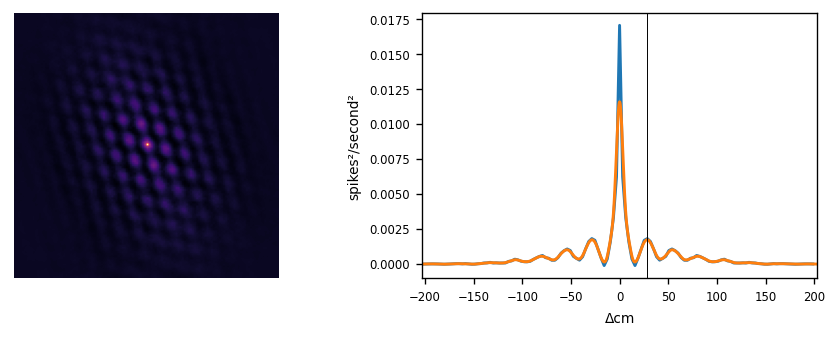

In [7]:
# Nv:    sample / bin
# K:     spikes / bin
# Δt:    seconds / t-bin
# Nt:    (samples/bin) × (seconds/sample) → seconds/bin
# Δx:    cm² / bin
# yb:    (spikes /bin) ÷ (seconds/bin)  → spikes/second
yb    = nan_to_num(K/Nt) # spikes/second

# (spikes/bin) ÷ (sample/bin) → spikes/sample
#λhat   = nan_to_num(K/Nv)

# Calibrate grid scale
λhat   = yb # spikes/second
acorr2 = fft_acorr(λhat,mask) # Get 2D autocorrelation
acorrR = radial_average(acorr2) # Get radial autocorrelation
res    = 50                     # Subsampling resolution
P,acup = acorr_peak(acorrR,res) # Distance to first peak in bins

subplot(121)
imshow(acorr2)
axis('off')

print('Period is %f cm (%f bins)'%(P*cm_p_bin,P))

subplot(122)
plot((arange(L)-L/2)*cm_p_bin,acorrR)
plot((linspace(-L/2,L/2,L*res))*cm_p_bin,acup)
xlim(-L/2*cm_p_bin,L/2*cm_p_bin)
xlabel('Δcm')
ylabel('spikes²/second²')
axvline(P*cm_p_bin,color='k',lw=0.5)

Text(0.5, 0.98, 'R1_20190823_2to1_EC_good.mat dataset 1')

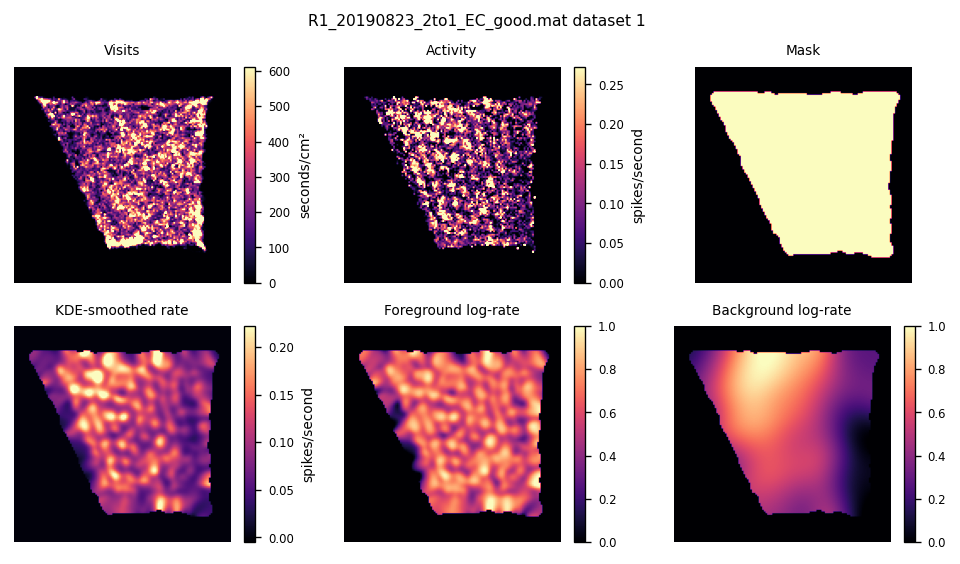

In [8]:
# Precompute variables; Passed as globals to jac/hess
fgσ  = P/pi           # In units of linear-bins
bgσ  = fgσ*5          # In units of linear-bins
n    = Nt.ravel()     # seconds/bin
y    = yb.ravel()     # spikes/second within each bin
λhat = kdeλ(Nt,K,fgσ) # KDE estimated rate
λbg  = kdeλ(Nt,K,bgσ) # Background rate
lλh  = slog(λhat)     # Log rate
lλb  = slog(λbg)      # Log background
lλf  = lλh - lλb      # Foreground log rate

# Initial guess for kernel height
σ0   = zerolag(radial_acorr(lλf,mask))

figure(figsize=(7,4))
subplot(231)
title('Visits');
axis('off')
imshow(Nt*Δx,vmin=percentile(Nt*Δx,5),vmax=percentile(Nt*Δx,95));
colorbar(label='seconds/cm²')
subplot(232)
title('Activity');
axis('off')
imshow(yb,vmin=percentile(yb,1),vmax=percentile(yb,95));
colorbar(label='spikes/second')
subplot(233)
showim(mask,'Mask');
subplots_adjust(top=0.8)
suptitle('%s dataset %d'%(dataset,idata))
subplot(234)
title('KDE-smoothed rate');
axis('off')
imshow(λhat*mask,vmin=percentile(λhat,1),vmax=percentile(λhat,99));
colorbar(label='spikes/second')
subplot(235)
showim(lλf,'Foreground log-rate',mask=mask);
colorbar()
subplot(236)
showim(lλb,'Background log-rate',mask=mask);
colorbar()
tight_layout()
suptitle('%s dataset %d'%(dataset,idata))

# Define hyperparameter search grid

- β is the kernel height
- P is the kernel period

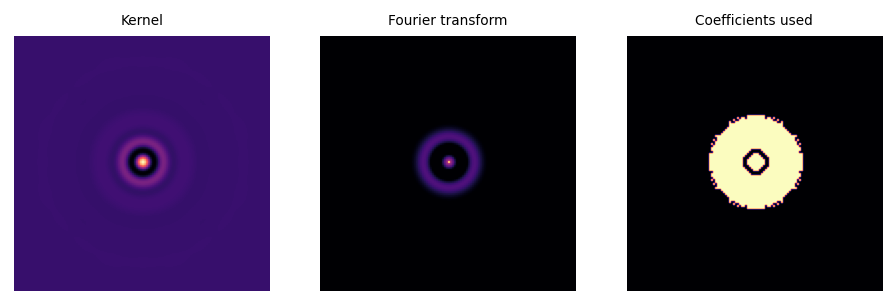

In [9]:
rP   = sqrt(2)
rβ   = 2
P_lo = P/rP
P_hi = P*rP
β_lo = 1/rβ
β_hi = 1*rβ
NP   = 9
Nβ   = 9
Ps   = float32(exp(linspace(log(P_lo),log(P_hi),NP)))
βs   = float32(exp(linspace(log(β_lo),log(β_hi),Nβ))[::-1])

@cache(NP*2)
def make_kernel_ft(L,P,σ0,dc=1e1,k=3):
    coords   = zgrid(L)
    window   = hanning(L)
    window   = fftshift(outer(window,window))
    kern     = j0(fftshift(abs(coords*2*pi/P)))*window
    clip     = fftshift(abs(coords)<P*jn_zeros(0,k)[-1]/(2*pi))
    kern     = kern*clip
    kern     = blur(kern,P/pi)
    kern     = repair_small_eigenvalues(kern*σ0/np.max(kern),1e-5)
    Kf       = np0.array(real(fft2(kern)))
    Kf[0,0] += dc
    return Kf

use2d = zeros((L,L),dtype='bool')
for p in Ps:
    Kf  = make_kernel_ft(L,p,σ0)
    thr = np.max(array(sorted(abs(Kf).ravel()))[:-1])
    thr = percentile(abs(Kf).ravel(),95)
    use2d |= (abs(Kf))>thr

# Define low-rank Fourier space projection 
use2d   = use2d | use2d.T    # Ensure symmetric
use     = find(use2d.ravel()) # Indecies into LxL array to use4
R        = len(use)            # Number of components used
down     = eye(T)[use]         # Matrix to trim down a Fourier transform 

# Define low-rank cuts for 1D transform
use1d  = any(use2d,axis=0)                 # Indecies to use along L
f1De   = fft(eye(L),norm='ortho')[use1d,:] # 1D Fourier components used
f1De   = complex64(f1De)
R1d    = sum(use1d)                        # Number of components used in the 1D tranform
usecut = find(use2d[:,use1d][use1d,:])     # Subset of reduced 1Dx1D transform kept in full 2D transform

def reverse(A):
    # Exchange positive and negative frequencies in a 2D fourier transform
    return roll(roll(A[::-1,:],1,axis=0)[:,::-1],1,axis=1)

# Positive/negative frequency flip in reduced representation
hperm = int32(down@reverse((down.T@(arange(R))).reshape(L,L)).ravel())

def er(a,b): print(max(abs(a-b)))
def hcv(kh,xh):
    kh = kh/2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)*xh+(kh-kr)*xr
def hcm(kh,xh):
    kh = kh/2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)[:,None]*xh+(kh-kr)[:,None]*xr
def Ftv(v):  # Collapse vector DOWN
    return fhtv(v)[use]
def Fv(v):
    #return fhtv(zeros(T).at[use].set(v))
    x = zeros(T)
    x[use] = v
    return x
def fhtv(v):
    v = fft2(v.reshape(L,L),norm='ortho').ravel()
    return v.real+v.imag
def fhtA(x):
    x = fft2(x.reshape(x.shape[0],L,L),norm='ortho').reshape(x.shape[0],T)
    return x.real+x.imag
def FtA(A):  # Collapse matrix DOWN
    return fhtA(A.T).T[use,:]
def FA(A): 
    # Syntax for jax
    # return fhtA(zeros((T,A.shape[-1])).at[use,:].set(A).T).T
    X = zeros((T,A.shape[-1]))
    X[use,:] = A
    return fhtA(X.T).T
def dv(Q):
    return sum(FA(tril(Q))**2,1)
def chol(x):
    return numpy.linalg.cholesky(x)
def ltinv(ch):
    q,info = scipy.linalg.lapack.dtrtri(ch,lower=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return q
def cv(K,v):
    return real(ifft2(fft2(v.reshape(L,L),norm='ortho')*K,norm='ortho')).ravel()
def cm(K,M):
    return real(ifft2(
        K[:,:,None]*fft2(M.reshape(L,L,M.shape[-1]),axes=(0,1)),
        axes=(0,1))).reshape(T,M.shape[-1])
def logdet(A):
    return sum(slog(diag(chol(A))))*2
    
# Precompute all manner of useful forms of a kernel
# TODO: check whether all of these are used
@cache(NP*2)
def prepare_kernel(p):
    Kf = make_kernel_ft(L,p,σ0)
    Λf = 1.0/Kf
    K0 = real(ifft2(Kf))
    Kh = (Kf.real+Kf.imag).ravel()[use]
    Λh = (Λf.real+Λf.imag).ravel()[use]
    sK = sum(log(Kf[use2d]))
    nK = sum(use2d)
    Λr = hcm(Λh,eye(R))
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = map(float32,[K0,Kf,Λf,Kh,Λh,sK,nK,Λr])
    return K0,Kf,Λf,Kh,Λh,sK,nK,Λr

K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(P)
subplot(131)
showkn(K0,'Kernel')
subplot(132)
showkn(Kf,'Fourier transform')
subplot(133)
showkn(use2d,'Coefficients used')

In [11]:
def chinv(X):
    X = float64(X)
    X = scipy.linalg.cholesky(X,lower=True)
    X,info = scipy.linalg.lapack.dtrtri(X,lower=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return X

def down(u):
    u = fft2(u.reshape(L,L),norm='ortho')[use2d]
    return u.real + u.imag

def up(u):
    x = zeros((L,L))
    x[use2d] = u
    x = fft2(x,norm='ortho').ravel()
    return x.real + x.imag

x = randn(T)
x = up(down(x))
print(allclose(up(down(x)),x))
imshow(up(down(mask)).reshape(L,L))
axis('off')

# Streamline precomputation of low-rank collapse of diagonal matrix
f1e = fft(eye(L),norm='ortho')[use1d,:]
f2e = f1e[:,None,:,None]*f1e[None,:,None,:]
h2e = f2e.real + f2e.imag
h2e = h2e.reshape(R1d*R1d,L*L)[usecut]

def fast_low_rank_covariance(nλ,β,p):
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    x   = sqrt(nλ)
    x   = x[None,:]*h2e
    xxt = x@x.T
    Λp  = β*diag(Λh) + xxt
    Cp  = chinv(Λp)
    Σp  = Cp.T @ Cp
    return Σp

def fast_covariance_diagonal(nλ,β,p):
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    x   = sqrt(nλ)
    x   = x[None,:]*h2e
    xxt = x@x.T
    Λp  = β*diag(Λh) + xxt
    A   = chinv(Λp)
    X  = zeros((L,L,R))
    X[use2d] = A.T
    DF = fft2(X,axes=(0,1),norm='ortho')
    DF = DF.real + DF.imag
    DF = DF.reshape(T,R).T
    return sum(DF**2,0)






# Double check that loss is correct 

In [14]:
fudge = sum(n)
fudge

numpy.set_printoptions(precision=5)

def logdet(A):
    return sum(log(diag(scipy.linalg.cholesky(A,lower=True))))*2

def loss(μ,v,β,p):
    '''
    n'(λ-y∘μ)  ½μ'Λ₀μ ½ln|Σ₀| -½ln|Σ| ½tr[Λ₀Σ]
    '''
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    λ   = exp(μ + μ0 + v/2)
    nλ  = n*λ
    Σr  = fast_low_rank_covariance(nλ,β,p)
    βΛΣ = β*Λr@Σr
    l1  = n@(λ-y*μ) # bins( s/bin*spike/s - spike/bin ) → spikes
    l2  = β*(μ@cv(Λf,μ)/2)
    l3  = -logdet(β*Λr)/2
    l4  = -logdet(Σr)/2
    l5  = trace(βΛΣ)/2
    return array([l1/fudge,l2/T,l3/T,l4/T,l5/T])

tic()
l1 = loss(μ,v,β,p)
tic('1')
print(l1)
print(sum(l1))

def loss_lowrank(μ,v,β,p):
    '''
    n'(λ-y∘μ)  ½μ'Λ₀μ ½ln|Σ₀| -½ln|Σ| ½tr[Λ₀Σ]
    '''
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    
    # Send μ to low-rank space
    μ   = ifft2(fft2(μ.reshape(L,L))*use2d).ravel().real
    
    λ   = exp(μ + μ0 + v/2)
    nλ  = n*λ
    Σr  = fast_low_rank_covariance(nλ,β,p)
    βΛΣ = β*Λr@Σr
    
    l1  = n@(λ-y*μ) # bins( s/bin*spike/s - spike/bin ) → spikes
    l2  = β*(μ@cv(Λf,μ)/2)
    l3  = -logdet(β*Λr)/2
    l4  = -logdet(Σr)/2
    l5  = trace(βΛΣ)/2
    return array([l1/fudge,l2/T,l3/T,l4/T,l5/T])

tic()
l2 = loss_lowrank(μ,v,β,p)
tic('2')
print(l2)
print(sum(l2))
print(abs(l1 - l2))

def loss_optimized(μ,v,β,p):
    '''
    n'(λ-y∘μ)  ½μ'Λ₀μ ½ln|Σ₀| -½ln|Σ| ½tr[Λ₀Σ]
    '''
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    μ   = ifft2(fft2(μ.reshape(L,L))*use2d).ravel().real
    λ   = exp(μ + μ0 + v/2)
    nλ  = n*λ
    x   = sqrt(nλ)[None,:]*h2e
    C   = chinv(β*diag(Λh) + x@x.T)
    l1  = n@(λ-y*μ) # bins( s/bin*spike/s - spike/bin ) → spikes
    l2  = β*(μ@cv(Λf,μ)/2) # 
    l3  = sK/2-nK*log(β)/2
    l4  = -sum(log(diag(C)))
    l5  = β*sum(C**2 * Λh.ravel())/2
    return array([l1/fudge,l2/T,l3/T,l4/T,l5/T])

# Why optimized look like reference, not low-rank?

tic()
l3 = loss_optimized(μ,v,β,p)
tic('2')
print(l3)
print(sum(l3))

print(abs(l3-l1))
print(abs(l3-l2))

compare = array([l1,l2,l3])
compare.T

In [16]:
compare = array([l1,l2,l3])
compare.T

array([[ 1.00193e-01,  5.60312e-01,  5.60312e-01],
       [ 5.87950e+04,  3.95669e+04,  3.95669e+04],
       [-2.18921e-01, -2.18921e-01, -2.18921e-01],
       [ 2.37613e-01,  2.42553e-01,  2.42553e-01],
       [ 4.19677e-02,  4.15755e-02,  4.15755e-02]])

In [39]:
N = Nv

# -L²ln(α) + α ln(α) n'y + α sum(K ln N) + α n'(y∘μ) + α n'(y∘μ₀) - αn'<λ> - sum(lnΓ[1 + αK]) >
constant1 = -L**2
constant2 = n@y
constant3 = nansum(K*log(N)).ravel()
constant4 = n@(y*μ0)
def loss_alpha(μ,v,α,β,p):
    '''
    n'(λ-y∘μ)  ½μ'Λ₀μ ½ln|Σ₀| -½ln|Σ| ½tr[Λ₀Σ]
    '''
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    μ   = ifft2(fft2(μ.reshape(L,L))*use2d).ravel().real
    λ   = exp(μ + μ0 + v/2)
    nλ  = n*λ
    # Note multiplying precision by α
    x   = sqrt(α*nλ)[None,:]*h2e
    C   = chinv(β*diag(Λh) + x@x.T)
    # α y ln(α λ) - α λ - ln Γ(1 + α y) - ln(α)
    # α y ln(α) + α y (μ + μ0) - α λ - ln Γ(1 + α y) - ln(α)
    #l1  = α*n@(λ-y*μ)
    #l1  = n@( α*y*log(α) + α*y*(μ-μ0) - α*λ - scipy.special.loggamma(1 + α*y) - log(α) )
    # -L²ln(α) + α ln(α) n'y + α sum(K ln N) + α n'(y∘μ) + α n'(y∘μ₀) - αn'<λ> - sum(lnΓ[1 + αK]) >
    l1 = constant1 * log(α) +\
         constant2 * α*log(α) +\
         constant3 * α +\
         n@(y*(μ+μ0)) * α +\
         -n@λ * α +\
         -sum(scipy.special.loggamma(1 + α*K))
    # bins( s/bin*spike/s - spike/bin ) → spikes
    l2  = β*(μ@cv(Λf,μ)/2) # 
    l3  = sK/2-nK*log(β)/2
    l4  = -sum(log(diag(C)))
    l5  = β*sum(C**2 * Λh.ravel())/2
    l1 = float(l1)
    return array([l1,l2,l3,l4,l5])

def fast_covariance_diagonal_alpha(nλ,α,β,p):
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    # Note multiplying precision by α
    x   = sqrt(α*nλ)
    x   = x[None,:]*h2e
    xxt = x@x.T
    Λp  = β*diag(Λh) + xxt
    A   = chinv(Λp)
    X  = zeros((L,L,R))
    X[use2d] = A.T
    DF = fft2(X,axes=(0,1),norm='ortho')
    DF = DF.real + DF.imag
    DF = DF.reshape(T,R).T
    return sum(DF**2,0)

def infer(μ,v,α,β,p,maxiter=100,showprogress=True):
    β = float(β)
    p = float(p)
    report = print if showprogress else lambda *x:()
    
    report('(initializing)')
    
    # Prepare kernel
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    Kβ = Kh/β
    Λβ = Λh*β

    # Preconditioner, in low-rank space
    M = op(R,lambda u:Kβ*u)
    
    # Send everything down into the low-rank space
    μh   = down(μ)
    vh   = down(v)
    μ0h  = down(μ0)
    
    report('(getting variance)')
    
    # Calculate rate with variance correction
    nλ   = n*exp(μ + μ0 + v/2)
    v    = fast_covariance_diagonal_alpha(nλ,α,β,p)
    
    report('(optimizing)')
    
    # Interleave mean and variance iterations
    for i in range(maxiter):
        
        # Inner loop optimizes the mean
        for j in range(maxiter):

            # Gradient, in low-rank space
            μ    = up(μh)
            λ    = exp(μ + μ0 + v/2)
            J    = Λβ*μh + α*down(n*(λ-y))

            # Hessian, in low-rank space
            nλ   = n*λ
            def Hu(u):
                return Λβ*u + α*down(nλ*up(u))

            Δμ = minres(op(R,Hu),J,tol=mintol,M=M)[0]
            μh -= Δμ
            if max(abs(Δμ))<tol: break
            report('μ',max(abs(Δμ)),'iteration',i,j)
            
        # Update the variance estimate
        report('(getting variance)')
        
        # Calculate rate with variance correction
        μ   = up(μh)
        nλ  = n*exp(μ + μ0 + v/2)
        v2  = fast_covariance_diagonal_alpha(nλ,α,β,p)
        Δv  = v2-v
        v   = v2
        
        report('Iteration',i)
        report('Δv',max(abs(Δv)))
        report('Δμ',max(abs(Δμ)))
        if max(abs(Δμ))<tol and max(abs(Δv))<tol: break
    
    return μ,v,loss_alpha(μ,v,α,β,p)

In [40]:
#%load_ext snakeviz
#%snakeviz 
β  = 1.0
μ  = lλf.ravel()
μ0 = lλb.ravel()
v  = 0.*μ
v  = μ*0
β  = 1
α  = 1
tic()
μ,v,l = infer(μ,v,α,β,P)
tic('took')

(initializing)
(getting variance)
(optimizing)
μ 1336.8916429869844 iteration 0 0
μ 9.267221383564655 iteration 0 1
μ 11.869279721709372 iteration 0 2
μ 13.615917057731508 iteration 0 3
μ 15.8577821776032 iteration 0 4
μ 18.979887647474577 iteration 0 5
μ 23.433431904061315 iteration 0 6
μ 28.872986795178107 iteration 0 7
μ 34.52403782917883 iteration 0 8
μ 38.15943426828395 iteration 0 9
μ 35.08668559420358 iteration 0 10
μ 18.963870412474144 iteration 0 11
μ 15.747860946938605 iteration 0 12
μ 12.947497695656537 iteration 0 13
μ 10.830227077892577 iteration 0 14
μ 5.15476117688097 iteration 0 15
μ 5.603253634535384 iteration 0 16
μ 3.484942068097879 iteration 0 17
μ 1.5742192154019765 iteration 0 18
μ 0.5130217583110774 iteration 0 19
μ 0.22352781046783785 iteration 0 20
μ 0.0557193688428226 iteration 0 21
μ 0.003560100033467772 iteration 0 22
(getting variance)
Iteration 0
Δv 0.016824274035979518
Δμ 1.376776374155149e-05
μ 0.025194808676355134 iteration 1 0
(getting variance)
Iterat

11779.969482421875

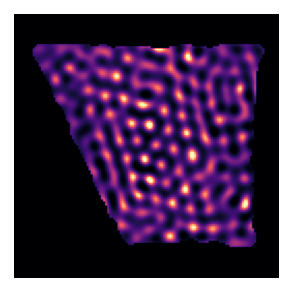

In [41]:
showim(exp((μ+v/2).reshape(L,L)),mask=mask)

# Sweep β and optimize 

In [42]:
# For jupyter notebooks: trigger browser to notify when done
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js('''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''.format(text=text)))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    #clear_output(False)
def notify(what='attention'):
    #os.system("echo -n '\a'")
    speak(what+'!')

In [43]:
results = []
for i,α in enumerate(βs):
    μ,v,l = infer(μ,v,α,β,P)
    results += [(μ,v,l)]
notify('DONE')

(initializing)
(getting variance)
(optimizing)
μ 3.146240726074422 iteration 0 0
μ 0.15988975127715177 iteration 0 1
μ 0.0002358623052946508 iteration 0 2
(getting variance)
Iteration 0
Δv 0.0035260648151304724
Δμ 3.4564669581235675e-07
μ 0.009772558436476618 iteration 1 0
(getting variance)
Iteration 1
Δv 1.0847061032936978e-05
Δμ 1.1078066066991851e-05
(initializing)
(getting variance)
(optimizing)
μ 0.34679843214816725 iteration 0 0
μ 0.0013612515891340432 iteration 0 1
(getting variance)
Iteration 0
Δv 0.0003527698860638709
Δμ 1.056647597081714e-06
μ 0.0009399962745509966 iteration 1 0
(getting variance)
Iteration 1
Δv 1.1484171216144534e-06
Δμ 8.677005911232222e-07
(initializing)
(getting variance)
(optimizing)
μ 0.3435344867435453 iteration 0 0
μ 0.0013642136199825395 iteration 0 1
(getting variance)
Iteration 0
Δv 0.0003540488780365905
Δμ 1.0643262265624686e-06
μ 0.000973812895677796 iteration 1 0
(getting variance)
Iteration 1
Δv 1.199375498868449e-06
Δμ 9.117717158879325e-07
(

<IPython.core.display.Javascript object>

In [48]:
shape(l)

(21, 5)

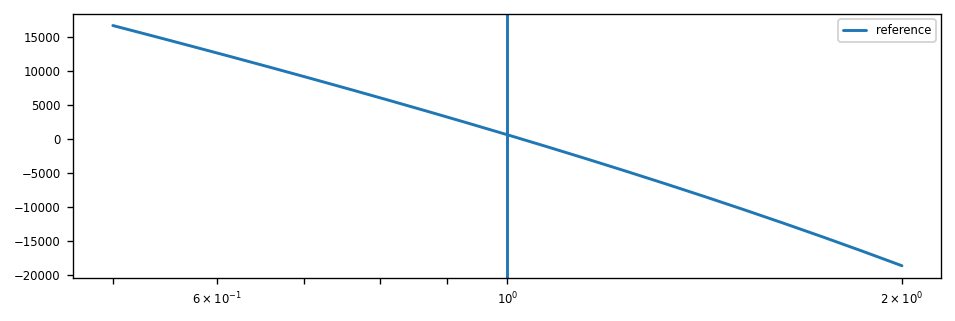

In [49]:
l = array([r[2] for r in results])
l1 = sum(l[:,:5],1)
#l2 = sum(l[:,5:10],1)
#l3 = sum(l[:,10:],1)
plot(βs,l1 - mean(l1),label='reference')
#plot(βs,l2 - mean(l2),label='low rank')
#plot(βs,l3 - mean(l3),label='optimized',linestyle=':',color='r')
semilogx()
axvline(1)
legend()

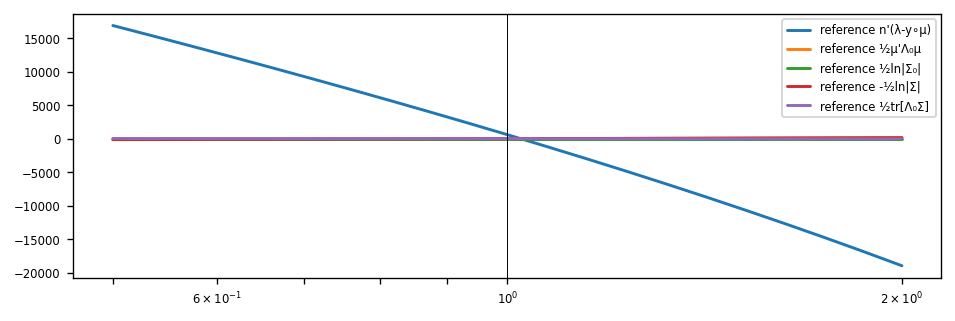

In [47]:
for i,name in enumerate("n'(λ-y∘μ)  ½μ'Λ₀μ ½ln|Σ₀| -½ln|Σ| ½tr[Λ₀Σ]".split()):
    plot(βs,l[:,i]-mean(l[:,i]),label='reference '+name)
    #plot(βs,l[:,i+5]-mean(l[:,i+5]),label='low-rank'+name)
    #plot(βs,l[:,i+10]-mean(l[:,i+10]),label='optimized'+name)
legend()
semilogx()
axvline(1,lw=0.5,color='k')
    

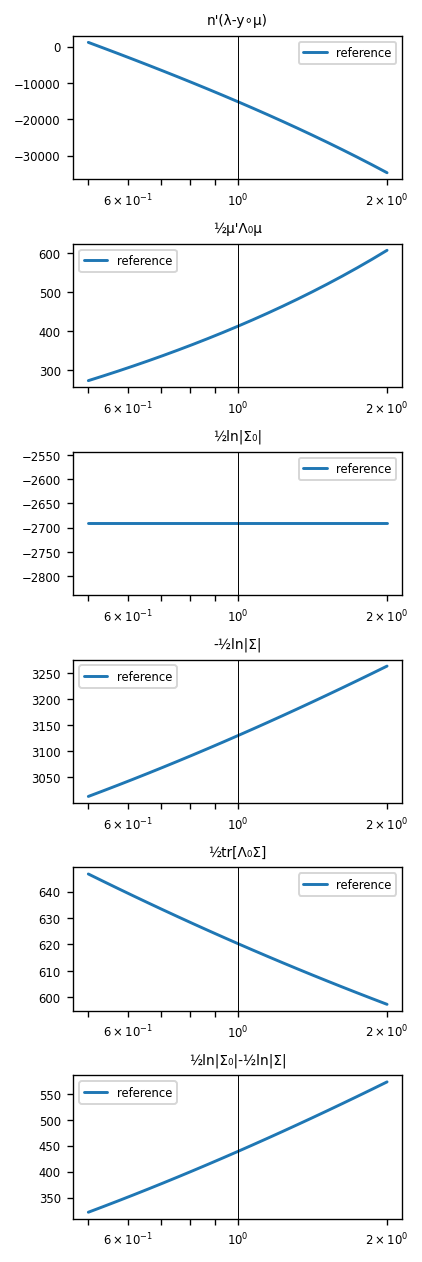

In [52]:
figure(figsize=(3,9))

for i,name in [*enumerate("n'(λ-y∘μ)  ½μ'Λ₀μ ½ln|Σ₀| -½ln|Σ| ½tr[Λ₀Σ]".split())]:#[:-2]:
    subplot(6,1,i+1)
    plot(βs,l[:,i],label='reference')
    #'plot(βs,l[:,i+5],label='low-rank')
    #'plot(βs,l[:,i+10],label='optimized')
    title(name)
    legend()
    semilogx()
    axvline(1,lw=0.5,color='k')
    
subplot(616)
plot(βs,l[:,2]+l[:,3],label='reference')
#'plot(βs,l[:,2+5]+l[:,3+5],label='low-rank')
#'plot(βs,l[:,2+10]+l[:,3+10],label='optimized')
title("½ln|Σ₀|-½ln|Σ|")
legend()
semilogx()
axvline(1,lw=0.5,color='k')

tight_layout()

In [ ]:
from IPython.display import clear_output

ip = NP//2
iβ = Nβ//2
p  = Ps[ip]
β  = βs[iβ]

μ,v,l = infer(μ,v,float(β),float(p))
print('\tβ[%d] ='%iβ,β,'\tloss = ',l)
μref,vref = μ,v

results = np0.empty((NP,Nβ),dtype='object')
def current_best():
    global results
    losses  = array([inf if r is None else np.sum(array(r[2])) for r in results.ravel()])
    bestidx = argmin(losses)
    bestP,bestβ = unravel_index(bestidx,results.shape)
    return bestP, bestβ, losses[bestidx]  
def search(ip,iβ,suggested_direction=None):
    global results
    # Return if out of bounds; Return memoized if possible; 
    if iβ<0 or ip<0 or iβ>=Nβ or ip>=NP: return
    if results[ip,iβ]: return
    
    print('P[%d]=%0.2f β[%d]=%0.2f'%(ip,Ps[ip],iβ,βs[iβ]))
    

    # Get initial conditions via extrapolation when possible
    if iβ+2<Nβ and results[ip,iβ+1] and results[ip,iβ+2]:
        (μ1,v1),(μ2,v2) = results[ip,iβ+1][:2], results[ip,iβ+2][:2]
        μ = 2*μ1 - μ2
        v = 2*v1 - v2
    elif iβ>=2 and results[ip,iβ-1] and results[ip,iβ-2]:
        (μ1,v1),(μ2,v2) = results[ip,iβ-1][:2], results[ip,iβ-2][:2]
        μ = 2*μ1 - μ2
        v = 2*v1 - v2
    elif iβ+1<Nβ and results[ip,iβ+1]: μ,v = results[ip,iβ+1][:2]
    elif iβ>=1   and results[ip,iβ-1]: μ,v = results[ip,iβ-1][:2]
    elif ip+1<NP and results[ip+1,iβ]: μ,v = results[ip+1,iβ][:2]
    elif ip>=1   and results[ip-1,iβ]: μ,v = results[ip-1,iβ][:2]
    else: μ,v = μref,vref
    
    β = βs[iβ]
    μ,v,l = infer(μ,v,float(β),float(p))
    results[ip,iβ] = (μ,v,l)
    print('P[%d]=%0.2f β[%d]=%0.2f loss=%f'%(ip,Ps[ip],iβ,βs[iβ],np.sum(array(l))))
    clear_output(wait=True)
    figure()
    imshow(array([sum(array(r[2])) if not r is None else nan for r in results.ravel()]).reshape(NP,Nβ))
    show()
    
    # Recursively search nearby
    search_directions = {(0,1),(0,-1),(1,0),(-1,0)}
    # Continue along previous trajectory, if any
    if not suggested_direction is None:
        Δp,Δβ = suggested_direction
        if current_best()[:2]==(ip,iβ):
            search(ip+Δp,iβ+Δβ,suggested_direction=(Δp,Δβ))
            search_directions -= {(Δp,Δβ)}
    # Try other trajectories
    for Δp,Δβ in search_directions:
        if current_best()[:2]!=(ip,iβ): break
        search(ip+Δp,iβ+Δβ,suggested_direction=(Δp,Δβ))
    return

ip = NP//2
iβ = Nβ//2
search(ip,iβ)

notify('DONE')

In [ ]:
bestP, bestβ = current_best()[:2]
μ,v,l = results[bestP,bestβ]
λ = exp(μ + μ0 + v/2)
subplot(121)
showim(λ.reshape(L,L),mask=mask)
subplot(122)
showim(1/v.reshape(L,L),mask=mask)
print('Optimized kernel height β=%f'%βs[bestβ])
print('Optimized kernel period P=%f'%Ps[bestP])

In [ ]:
imshow(μ.reshape(L,L))
colorbar()

In [ ]:
p = Ps[bestP]

In [ ]:
β = βs[bestβ]

In [ ]:
'''
Use low-pass filtered velocity angle as heading 
Positive dx is eastwards
Negative dx is westwards
Positive dy is northwards
Negative dy is southwards
Angle is computed as if a complex number
North is +90, West is ±180, South is -90, and East is 0.
So, sin(θ) is the vertical direction, with sin(θ)=1 being northwards.
Likewise cos(θ) is the horizontal direction, with cos(θ)=1 being eastwards.
North: positive sin(θ)
South: negative sin(θ)
East : positive cos(θ)
West : negative cos(θ)
φ=0    : West
φ=1/2π : South
φ=π    : East
φ=3/2π : North
'''
φW,φS,φE,φN = 0, pi/2, pi, 3*pi/2
φs  = linspace(0,2*pi,90+1)[:-1]
φiW = argmin(abs(φs-φW))
φiS = argmin(abs(φs-φS))
φiE = argmin(abs(φs-φE))
φiN = argmin(abs(φs-φN))